In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure this is imported for pairwise_distance
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from PIL import Image




In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Adjust the input size of fc1 based on the output of conv3 (after pooling and flattening)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjust based on the output size of conv layers
        self.fc2 = nn.Linear(512, 256)

    def forward_once(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # 32x32 -> 16x16
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # 16x16 -> 8x8
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)  # 8x8 -> 4x4

        x = x.view(x.size(0), -1)  # Flatten the tensor from (256, 4, 4) to (256*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2


In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        img1, label1 = self.dataset[index]
        should_get_same_class = np.random.randint(0, 2)
        if should_get_same_class:
            while True:
                img2, label2 = self.dataset[np.random.randint(0, len(self.dataset))]
                if label1 == label2:
                    break
        else:
            while True:
                img2, label2 = self.dataset[np.random.randint(0, len(self.dataset))]
                if label1 != label2:
                    break
        return img1, img2, torch.tensor([int(label1 == label2)], dtype=torch.float32)

    def __len__(self):
        return len(self.dataset)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataset = SiameseDataset(trainset)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Siamese Network model
model = SiameseNetwork().to(device)


Files already downloaded and verified


In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)  # This uses the F alias
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

# Initialize loss function and optimizer
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} started")
        running_loss = 0.0
        for batch_idx, (img1, img2, label) in enumerate(train_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()

            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/(batch_idx+1):.4f}')

        print(f"Epoch {epoch+1}/{epochs} completed. Average Loss: {running_loss/len(train_loader):.4f}\n")

# Run the training process
train_model(model, train_loader, criterion, optimizer, epochs=5)


Epoch 1/5 started
Epoch [1/5], Batch [50/1563], Loss: 0.3147
Epoch [1/5], Batch [100/1563], Loss: 0.2922
Epoch [1/5], Batch [150/1563], Loss: 0.2842
Epoch [1/5], Batch [200/1563], Loss: 0.2806
Epoch [1/5], Batch [250/1563], Loss: 0.2772
Epoch [1/5], Batch [300/1563], Loss: 0.2744
Epoch [1/5], Batch [350/1563], Loss: 0.2732
Epoch [1/5], Batch [400/1563], Loss: 0.2718
Epoch [1/5], Batch [450/1563], Loss: 0.2709
Epoch [1/5], Batch [500/1563], Loss: 0.2701
Epoch [1/5], Batch [550/1563], Loss: 0.2690
Epoch [1/5], Batch [600/1563], Loss: 0.2683
Epoch [1/5], Batch [650/1563], Loss: 0.2674
Epoch [1/5], Batch [700/1563], Loss: 0.2671
Epoch [1/5], Batch [750/1563], Loss: 0.2669
Epoch [1/5], Batch [800/1563], Loss: 0.2666
Epoch [1/5], Batch [850/1563], Loss: 0.2666
Epoch [1/5], Batch [900/1563], Loss: 0.2664
Epoch [1/5], Batch [950/1563], Loss: 0.2660
Epoch [1/5], Batch [1000/1563], Loss: 0.2655
Epoch [1/5], Batch [1050/1563], Loss: 0.2651
Epoch [1/5], Batch [1100/1563], Loss: 0.2647
Epoch [1/5],

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
# Create a DataLoader for testing
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataset = SiameseDataset(test_dataset)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

# Testing function
def test_model(model, test_loader, threshold=1.0):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculations
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            output1, output2 = model(img1, img2)
            euclidean_distance = F.pairwise_distance(output1, output2)

            # Determine predictions based on the threshold
            predictions = (euclidean_distance < threshold).float().view(-1)

            correct += (predictions == label.view(-1)).sum().item()
            total += label.size(0)

    accuracy = 100 * correct / total
    print(f'Testing Accuracy: {accuracy:.2f}%')
    return accuracy

# Call the testing function after training
test_model(model, test_loader, threshold=1.0)


Files already downloaded and verified
Testing Accuracy: 50.08%


50.08

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def visualize_image_retrieval(model, dataset, class1_idx, class2_idx, num_images=5):
    model.eval()

    # Get images and labels for the selected classes
    class1_images = [i for i, (_, label) in enumerate(dataset) if label == class1_idx]
    class2_images = [i for i, (_, label) in enumerate(dataset) if label == class2_idx]

    # Randomly select images from the classes
    selected_class1_images = np.random.choice(class1_images, num_images, replace=False)
    selected_class2_images = np.random.choice(class2_images, num_images, replace=False)

    # Prepare to plot images
    fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

    for i in range(num_images):
        img1_index = selected_class1_images[i]
        img2_index = selected_class2_images[i]

        # Get images and labels
        img1, label1 = dataset[img1_index]
        img2, label2 = dataset[img2_index]

        # Transform images to the required format (if needed)
        img1 = img1.unsqueeze(0).to(device)  # Add batch dimension and move to device
        img2 = img2.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get feature outputs from the model
        output1, output2 = model(img1, img2)

        # Calculate Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2).item()  # Convert to scalar

        # Convert images back to CPU for visualization
        img1 = img1.squeeze(0).cpu().detach().numpy()
        img2 = img2.squeeze(0).cpu().detach().numpy()

        # Plot the images
        axes[i, 0].imshow(np.transpose(img1, (1, 2, 0)))  # Transpose to (H, W, C)
        axes[i, 0].set_title(f'Image 1 (Label: {label1})')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.transpose(img2, (1, 2, 0)))
        axes[i, 1].set_title(f'Image 2 (Label: {label2})')
        axes[i, 1].axis('off')

    plt.suptitle(f'Euclidean Distances for {num_images} Image Pairs')
    plt.show()


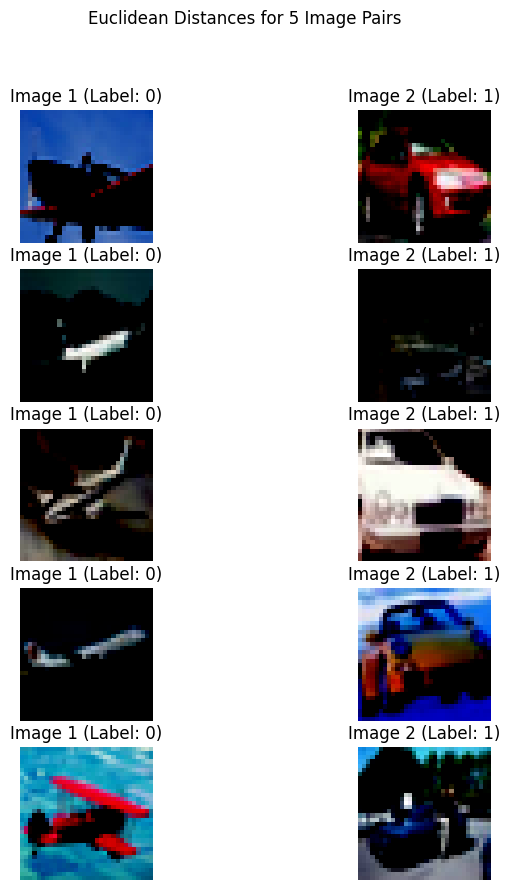

In [ ]:
# Assuming you have a dataset variable defined
visualize_image_retrieval(model, trainset, index1=0, index2=1)  # Change indices as needed
